In [3]:
# ===============================
# CELL 1: Import Libraries
# ===============================
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import numpy as np
from pathlib import Path

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [6]:
# ===============================
# CELL 2: Load Dataset
# ===============================
def load_jsonl(file_path):
    """Load JSONL file into list of dictionaries"""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

def load_dataset(data_dir="loan_dataset"):
    """Load all splits of the dataset"""
    data_dir = Path(data_dir)

    datasets = {}
    for split in ["train", "val", "test"]:
        file_path = data_dir / f"{split}.jsonl"
        if file_path.exists():
            datasets[split] = load_jsonl(file_path)
            print(f"Loaded {len(datasets[split])} samples from {split}.jsonl")
        else:
            print(f"Warning: {file_path} not found")

    # Load statistics if available
    stats_file = data_dir / "dataset_stats.json"
    if stats_file.exists():
        with open(stats_file, 'r') as f:
            stats = json.load(f)
        print(f"\nDataset Statistics:")
        print(f"Total samples: {stats['total_samples']}")
        print(f"Class distribution: {stats['class_distribution']}")
        datasets['stats'] = stats

    return datasets

# Load the dataset
datasets = load_dataset("../data/")  # Change path if needed


Loaded 12000 samples from train.jsonl
Loaded 1500 samples from val.jsonl
Loaded 1500 samples from test.jsonl

Dataset Statistics:
Total samples: 15000
Class distribution: {'APPROVE': 5000, 'REJECT': 5000, 'FLAG_REVIEW': 5000}


In [7]:
# ===============================
# CELL 3: Basic Data Exploration
# ===============================
def explore_dataset(datasets):
    """Basic exploration of the dataset"""

    print("=== DATASET OVERVIEW ===")
    for split_name, split_data in datasets.items():
        if split_name == 'stats':
            continue
        print(f"\n{split_name.upper()} SET:")
        print(f"  Samples: {len(split_data)}")

        # Extract results from assistant responses
        results = []
        for sample in split_data:
            assistant_msg = sample['messages'][-1]['content']
            result_data = json.loads(assistant_msg)
            results.append(result_data['result'])

        result_counts = Counter(results)
        print(f"  Class distribution: {dict(result_counts)}")

        # Show sample
        print(f"\n  Sample from {split_name}:")
        sample = split_data[0]
        user_content = json.loads(sample['messages'][1]['content'])
        assistant_content = json.loads(sample['messages'][2]['content'])

        print(f"    Application: Age={user_content['age']}, "
              f"Credit={user_content['credit_score']}, "
              f"Income=${user_content['annual_income_usd']:,}")
        print(f"    Decision: {assistant_content['result']}")
        print(f"    Reasoning: {assistant_content['reasoning'][:100]}...")

explore_dataset(datasets)

=== DATASET OVERVIEW ===

TRAIN SET:
  Samples: 12000
  Class distribution: {'FLAG_REVIEW': 3977, 'APPROVE': 4004, 'REJECT': 4019}

  Sample from train:
    Application: Age=37, Credit=733, Income=$103,066
    Decision: FLAG_REVIEW
    Reasoning: Employment duration 2 months less than 6. Requested loan amount $66,614 exceeds 50% of annual income...

VAL SET:
  Samples: 1500
  Class distribution: {'REJECT': 509, 'APPROVE': 480, 'FLAG_REVIEW': 511}

  Sample from val:
    Application: Age=52, Credit=688, Income=$111,092
    Decision: REJECT
    Reasoning: Employment status 'unemployed' is not allowed....

TEST SET:
  Samples: 1500
  Class distribution: {'APPROVE': 516, 'REJECT': 472, 'FLAG_REVIEW': 512}

  Sample from test:
    Application: Age=45, Credit=840, Income=$126,898
    Decision: APPROVE
    Reasoning: All criteria met for approval....


In [9]:
# ===============================
# CELL 4: Convert to DataFrames for Analysis
# ===============================
def convert_to_dataframe(dataset_split):
    """Convert JSONL dataset to pandas DataFrame"""
    rows = []

    for sample in dataset_split:
        # Extract application data (user message)
        app_data = json.loads(sample['messages'][1]['content'])

        # Extract evaluation result (assistant message)
        eval_data = json.loads(sample['messages'][2]['content'])

        # Combine into single row
        row = {
            **app_data,  # All application fields
            'decision': eval_data['result'],
            'reasoning': eval_data['reasoning']
        }
        rows.append(row)

    return pd.DataFrame(rows)

# Convert datasets to DataFrames
dfs = {}
for split_name, split_data in datasets.items():
    if split_name != 'stats':
        dfs[split_name] = convert_to_dataframe(split_data)
        print(f"Converted {split_name} to DataFrame: {dfs[split_name].shape}")

# Display train set info
print(f"\nTrain DataFrame Info:")
print(dfs['train'].info())
print(f"\nTrain DataFrame Head:")
dfs['train'].head()

Converted train to DataFrame: (12000, 12)
Converted val to DataFrame: (1500, 12)
Converted test to DataFrame: (1500, 12)

Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 12000 non-null  int64  
 1   credit_score                        12000 non-null  int64  
 2   annual_income_usd                   12000 non-null  int64  
 3   debt_to_income_ratio_percent        12000 non-null  float64
 4   employment_status                   12000 non-null  object 
 5   current_employment_duration_months  12000 non-null  int64  
 6   residency_status                    12000 non-null  object 
 7   has_bankruptcy_recent               12000 non-null  bool   
 8   requested_amount_usd                12000 non-null  int64  
 9   has_verifiable_bank_account

,age,credit_score,annual_income_usd,debt_to_income_ratio_percent,employment_status,current_employment_duration_months,residency_status,has_bankruptcy_recent,requested_amount_usd,has_verifiable_bank_account,decision,reasoning
0,37,733,103066,28.48,retired,2,US_Citizen,False,66614,True,FLAG_REVIEW,Employment duration 2 months less than 6. Requ...
1,25,675,55054,15.72,self_employed,4,Permanent_Resident,False,29822,True,FLAG_REVIEW,Employment duration 4 months less than 6. Requ...
2,49,742,113879,15.30,employed_part_time,18,Permanent_Resident,False,44839,True,APPROVE,All criteria met for approval.
3,49,717,58460,19.88,retired,32,US_Citizen,False,7911,True,APPROVE,All criteria met for approval.
4,64,779,96245,17.46,employed_full_time,37,US_Citizen,False,26161,True,APPROVE,All criteria met for approval.


=== Training Set Analysis ===
Shape: (12000, 12)
Columns: ['age', 'credit_score', 'annual_income_usd', 'debt_to_income_ratio_percent', 'employment_status', 'current_employment_duration_months', 'residency_status', 'has_bankruptcy_recent', 'requested_amount_usd', 'has_verifiable_bank_account', 'decision', 'reasoning']

Decision Distribution:
decision
REJECT         4019
APPROVE        4004
FLAG_REVIEW    3977
Name: count, dtype: int64


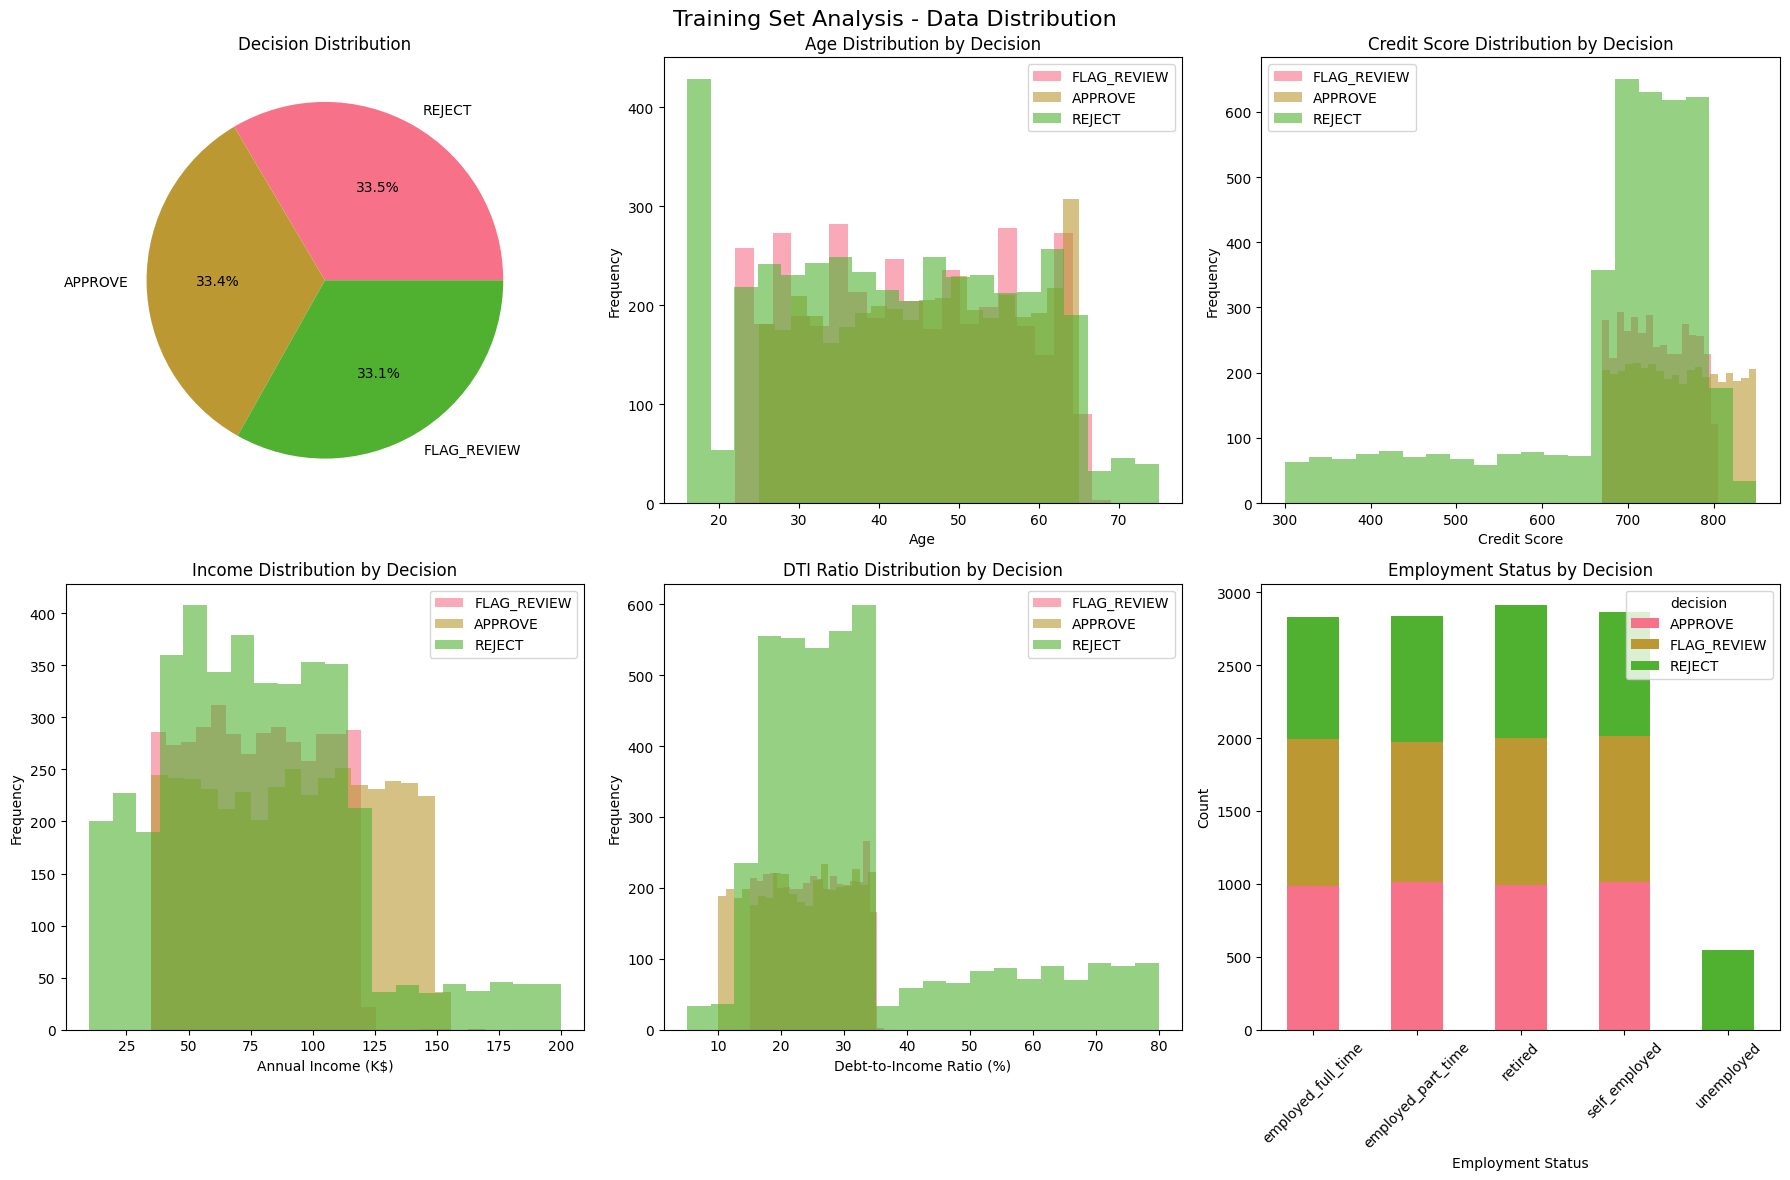

In [10]:
# ===============================
# CELL 5: Data Analysis and Visualization
# ===============================
def analyze_dataset(df, title="Dataset Analysis"):
    """Comprehensive analysis of the dataset"""

    print(f"=== {title} ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # Class distribution
    print(f"\nDecision Distribution:")
    decision_counts = df['decision'].value_counts()
    print(decision_counts)

    # Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{title} - Data Distribution', fontsize=16)

    # 1. Decision distribution (pie chart)
    axes[0, 0].pie(decision_counts.values, labels=decision_counts.index, autopct='%1.1f%%')
    axes[0, 0].set_title('Decision Distribution')

    # 2. Age distribution by decision
    for decision in df['decision'].unique():
        subset = df[df['decision'] == decision]['age']
        axes[0, 1].hist(subset, alpha=0.6, label=decision, bins=20)
    axes[0, 1].set_xlabel('Age')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Age Distribution by Decision')
    axes[0, 1].legend()

    # 3. Credit score distribution by decision
    for decision in df['decision'].unique():
        subset = df[df['decision'] == decision]['credit_score']
        axes[0, 2].hist(subset, alpha=0.6, label=decision, bins=20)
    axes[0, 2].set_xlabel('Credit Score')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Credit Score Distribution by Decision')
    axes[0, 2].legend()

    # 4. Income distribution by decision
    df['income_k'] = df['annual_income_usd'] / 1000
    for decision in df['decision'].unique():
        subset = df[df['decision'] == decision]['income_k']
        axes[1, 0].hist(subset, alpha=0.6, label=decision, bins=20)
    axes[1, 0].set_xlabel('Annual Income (K$)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Income Distribution by Decision')
    axes[1, 0].legend()

    # 5. Debt-to-income ratio by decision
    for decision in df['decision'].unique():
        subset = df[df['decision'] == decision]['debt_to_income_ratio_percent']
        axes[1, 1].hist(subset, alpha=0.6, label=decision, bins=20)
    axes[1, 1].set_xlabel('Debt-to-Income Ratio (%)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('DTI Ratio Distribution by Decision')
    axes[1, 1].legend()

    # 6. Employment status distribution
    emp_decision = pd.crosstab(df['employment_status'], df['decision'])
    emp_decision.plot(kind='bar', ax=axes[1, 2], stacked=True)
    axes[1, 2].set_title('Employment Status by Decision')
    axes[1, 2].set_xlabel('Employment Status')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return df

# Analyze train set
train_analysis = analyze_dataset(dfs['train'], "Training Set Analysis")

In [11]:
# ===============================
# CELL 6: Sample Data Inspection
# ===============================
def inspect_samples(df, n_samples=3):
    """Inspect sample data for each decision type"""

    print("=== SAMPLE INSPECTION ===")

    for decision in df['decision'].unique():
        print(f"\n{decision} SAMPLES:")
        subset = df[df['decision'] == decision].head(n_samples)

        for idx, (_, row) in enumerate(subset.iterrows(), 1):
            print(f"\n  Sample {idx}:")
            print(f"    Age: {row['age']}, Credit: {row['credit_score']}, "
                  f"Income: ${row['annual_income_usd']:,}")
            print(f"    DTI: {row['debt_to_income_ratio_percent']}%, "
                  f"Employment: {row['employment_status']}")
            print(f"    Residency: {row['residency_status']}, "
                  f"Bankruptcy: {row['has_bankruptcy_recent']}")
            print(f"    Requested: ${row['requested_amount_usd']:,}, "
                  f"Bank Account: {row['has_verifiable_bank_account']}")
            print(f"    Decision: {row['decision']}")
            print(f"    Reasoning: {row['reasoning']}")

inspect_samples(dfs['train'])

=== SAMPLE INSPECTION ===

FLAG_REVIEW SAMPLES:

  Sample 1:
    Age: 37, Credit: 733, Income: $103,066
    DTI: 28.48%, Employment: retired
    Residency: US_Citizen, Bankruptcy: False
    Requested: $66,614, Bank Account: True
    Decision: FLAG_REVIEW
    Reasoning: Employment duration 2 months less than 6. Requested loan amount $66,614 exceeds 50% of annual income $103,066.

  Sample 2:
    Age: 25, Credit: 675, Income: $55,054
    DTI: 15.72%, Employment: self_employed
    Residency: Permanent_Resident, Bankruptcy: False
    Requested: $29,822, Bank Account: True
    Decision: FLAG_REVIEW
    Reasoning: Employment duration 4 months less than 6. Requested loan amount $29,822 exceeds 50% of annual income $55,054.

  Sample 3:
    Age: 48, Credit: 695, Income: $58,899
    DTI: 20.0%, Employment: retired
    Residency: Permanent_Resident, Bankruptcy: False
    Requested: $44,680, Bank Account: True
    Decision: FLAG_REVIEW
    Reasoning: Employment duration 5 months less than 6. Requ

In [13]:
# ===============================
# CELL 7: Quick Stats Summary
# ===============================
def print_summary(datasets):
    """Print final summary"""

    print("=== DATASET SUMMARY ===")
    total_samples = sum(len(data) for name, data in datasets.items() if name != 'stats')
    print(f"Total samples: {total_samples}")

    for split_name, split_data in datasets.items():
        if split_name == 'stats':
            continue

        results = [json.loads(sample['messages'][-1]['content'])['result']
                  for sample in split_data]
        result_counts = Counter(results)

        print(f"\n{split_name.upper()}:")
        print(f"  Samples: {len(split_data)}")
        for result, count in result_counts.items():
            percentage = (count / len(split_data)) * 100
            print(f"  {result}: {count} ({percentage:.1f}%)")

    print(f"\nFiles ready for training:")
    print(f"  Training: prepared_train_data.jsonl")
    print(f"  Validation: prepared_val_data.jsonl")

print_summary(datasets)

=== DATASET SUMMARY ===
Total samples: 15000

TRAIN:
  Samples: 12000
  FLAG_REVIEW: 3977 (33.1%)
  APPROVE: 4004 (33.4%)
  REJECT: 4019 (33.5%)

VAL:
  Samples: 1500
  REJECT: 509 (33.9%)
  APPROVE: 480 (32.0%)
  FLAG_REVIEW: 511 (34.1%)

TEST:
  Samples: 1500
  APPROVE: 516 (34.4%)
  REJECT: 472 (31.5%)
  FLAG_REVIEW: 512 (34.1%)

Files ready for training:
  Training: prepared_train_data.jsonl
  Validation: prepared_val_data.jsonl
